In [1]:
import csv
from unicodedata import normalize
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import seaborn as sns
import numpy as np
import re
import locale

locale.setlocale(locale.LC_TIME, '')

'Portuguese_Brazil.1252'

In [2]:
ANOS_ESTRATO = 10

def limpar(estratif):
	ks = ['Cod_setor']+list(estratos.keys())
	df = estratif[ks]
	return df

def acharEstrato(idade,step=ANOS_ESTRATO):
    round_ceil = (100//step)*step
    if idade<round_ceil:
        tag_floor = str(int(idade//step)*step)
        if (int(idade//step + 1)*step)-1 >= round_ceil:
            tag_ceil = str(round_ceil-1)
        else:
            tag_ceil = str((int(idade//step + 1)*step)-1)
        return f'{tag_floor}a{tag_ceil}'
    else:
        tag_limit = str(int(round_ceil//step)*step)
        return f'{tag_limit}m'

def acharSexoEstrato(sexo,idade,step=ANOS_ESTRATO):
    if sexo.upper().startswith('F'):
        sex = 'F'
    elif sexo.upper().startswith('M'):
        sex = 'M'
    else:
        print(sexo)
        raise Exception
    age = acharEstrato(idade,step)
    return f'{sex}_{age}'
    
def acharQuinzena(datestring, dateformat='%Y-%m-%d', datezero = datetime(2020,1,1)):
    datetarget = datetime.strptime(datestring, dateformat)
    datedelta = datetarget - datezero
    deltadays = datedelta.days
    quinzena = (deltadays//15) + 1
    return quinzena

## Import vacinas

In [3]:
file = "Vac_RMSP_20211020_fullDB.csv"
df = pd.read_csv(file,sep='	',nrows=1,dtype={'paciente_endereco_cep':str})
df.keys()

Index(['paciente_idade', 'paciente_datanascimento',
       'paciente_enumsexobiologico', 'paciente_racacor_codigo',
       'paciente_racacor_valor', 'paciente_endereco_coibgemunicipio',
       'paciente_endereco_copais', 'paciente_endereco_nmmunicipio',
       'paciente_endereco_nmpais', 'paciente_endereco_uf',
       'paciente_endereco_cep', 'paciente_nacionalidade_enumnacionalidade',
       'estabelecimento_valor', 'estabelecimento_razaosocial',
       'estalecimento_nofantasia', 'estabelecimento_municipio_codigo',
       'estabelecimento_municipio_nome', 'estabelecimento_uf',
       'vacina_grupoatendimento_codigo', 'vacina_grupoatendimento_nome',
       'vacina_categoria_codigo', 'vacina_categoria_nome', 'vacina_lote',
       'vacina_fabricante_nome', 'vacina_fabricante_referencia',
       'vacina_dataaplicacao', 'vacina_descricao_dose', 'vacina_codigo',
       'vacina_nome', 'sistema_origem', 'data_importacao_rnds',
       'id_sistema_origem'],
      dtype='object')

In [4]:
filecep = "ceps_aps.csv"
col_list = ['paciente_idade',
            'paciente_endereco_cep',
            'paciente_enumsexobiologico',
            'vacina_descricao_dose',
            'vacina_grupoatendimento_nome',
            'vacina_categoria_nome',
            'vacina_nome',
            'vacina_dataaplicacao',
            'vacina_codigo',
            'vacina_nome',
            'paciente_endereco_nmmunicipio']

In [5]:
#df = pd.read_csv(file,sep='	',usecols=col_list,nrows=10000,dtype={'paciente_endereco_cep':str})
df = pd.read_csv(file,sep='	',usecols=col_list,dtype={'paciente_endereco_cep':str})
df.drop_duplicates(inplace=True)
df.head()

,paciente_idade,paciente_enumsexobiologico,paciente_endereco_nmmunicipio,paciente_endereco_cep,vacina_grupoatendimento_nome,vacina_categoria_nome,vacina_dataaplicacao,vacina_descricao_dose,vacina_codigo,vacina_nome
0,73,F,SAO PAULO,03591,Pessoas de 70 a 74 anos,Faixa Etária,2021-04-12,2a Dose,86,COVID-19 SINOVAC/BUTANTAN - CORONAVAC
1,32,M,SAO PAULO,01325,Pessoas de 18 a 64 anos,Faixa Etária,2021-08-18,2a Dose,86,COVID-19 SINOVAC/BUTANTAN - CORONAVAC
2,38,F,SAO PAULO,NaN,Outros,Trabalhadores de Saúde,2021-03-08,1a Dose,86,COVID-19 SINOVAC/BUTANTAN - CORONAVAC
3,62,M,SAO PAULO,NaN,Pessoas de 18 a 64 anos,Faixa Etária,2021-05-06,1a Dose,87,COVID-19 PFIZER - COMIRNATY
4,48,F,SAO PAULO,NaN,Pessoas de 18 a 64 anos,Faixa Etária,2021-09-22,2a Dose,85,COVID-19 ASTRAZENECA/FIOCRUZ - COVISHIELD


### Código das vacinas
| Código | Descrição | Apelido |
|--------|-----------|---------|
|86|Covid-19-Coronavac-Sinovac/Butantan|Coronavac|
|85|Vacina Covid-19 - Covishield|Astrazeneca|
|87|Vacina covid-19 - BNT162b2 - BioNTech/Fosun Pharma/Pfizer|Pfizer|
|88|Vacina covid-19 - Ad26.COV2.S - Janssen-Cilag|Janssen|

In [6]:
apelido_vacinas = {
    86:'Coronavac',
    85:'Astrazeneca',
    87:'Pfizer',
    88:'Janssen'
}

df['vacina'] = df['vacina_codigo'].apply(lambda x: apelido_vacinas[x])

In [7]:
df['vacina_descricao_dose'].unique()

array(['2a Dose', '1a Dose', 'Dose', 'Dose Adicional', 'Reforço',
       'Única', '3a Dose', '1a Dose Revacinação',
       '2a Dose Revacinação', 'Dose Inicial'], dtype=object)

In [8]:
df[['vacina','vacina_descricao_dose']].drop_duplicates().sort_values(by=['vacina','vacina_descricao_dose'])

,vacina,vacina_descricao_dose
7,Astrazeneca,1a Dose
4,Astrazeneca,2a Dose
843130,Astrazeneca,Dose Adicional
843743,Astrazeneca,Reforço
2,Coronavac,1a Dose
0,Coronavac,2a Dose
20101335,Coronavac,2a Dose Revacinação
4535217,Coronavac,3a Dose
843047,Coronavac,Dose Adicional
30609573,Coronavac,Dose Inicial


In [9]:
def avaliarImunizacao(row):
    if row['vacina_codigo']==88: # Vacina Janssen
        return 'completa'
    elif row['vacina_descricao_dose']=='2a Dose':
        return 'completa'
    elif row['vacina_descricao_dose']=='1a Dose':
        return 'incompleta'
    else:
        return 'reforço'
    


df['quinzena_aplicacao'] = df['vacina_dataaplicacao'].apply(acharQuinzena)
df['status_pessoa'] = df.apply(avaliarImunizacao,axis=1)
df['estrato_etario'] = df['paciente_idade'].apply(acharEstrato)
df['grau_imunizacao'] = df['vacina'].apply(lambda x: 1 if x=='Janssen' else 0.5)

df.head()

,paciente_idade,paciente_enumsexobiologico,paciente_endereco_nmmunicipio,paciente_endereco_cep,vacina_grupoatendimento_nome,vacina_categoria_nome,vacina_dataaplicacao,vacina_descricao_dose,vacina_codigo,vacina_nome,vacina,quinzena_aplicacao,status_pessoa,estrato_etario,grau_imunizacao
0,73,F,SAO PAULO,03591,Pessoas de 70 a 74 anos,Faixa Etária,2021-04-12,2a Dose,86,COVID-19 SINOVAC/BUTANTAN - CORONAVAC,Coronavac,32,completa,70a79,0.5
1,32,M,SAO PAULO,01325,Pessoas de 18 a 64 anos,Faixa Etária,2021-08-18,2a Dose,86,COVID-19 SINOVAC/BUTANTAN - CORONAVAC,Coronavac,40,completa,30a39,0.5
2,38,F,SAO PAULO,NaN,Outros,Trabalhadores de Saúde,2021-03-08,1a Dose,86,COVID-19 SINOVAC/BUTANTAN - CORONAVAC,Coronavac,29,incompleta,30a39,0.5
3,62,M,SAO PAULO,NaN,Pessoas de 18 a 64 anos,Faixa Etária,2021-05-06,1a Dose,87,COVID-19 PFIZER - COMIRNATY,Pfizer,33,incompleta,60a69,0.5
4,48,F,SAO PAULO,NaN,Pessoas de 18 a 64 anos,Faixa Etária,2021-09-22,2a Dose,85,COVID-19 ASTRAZENECA/FIOCRUZ - COVISHIELD,Astrazeneca,43,completa,40a49,0.5


In [10]:
df = df[['paciente_endereco_cep','vacina','vacina_descricao_dose','status_pessoa','quinzena_aplicacao','estrato_etario','vacina_grupoatendimento_nome','vacina_categoria_nome','grau_imunizacao','paciente_endereco_nmmunicipio']]
#df = df.query('quinzena_aplicacao>=34')
df.fillna(0,inplace=True)
df['char_cep'] = df['paciente_endereco_cep'].apply(lambda x: len(str(int(x))))
df['validade_cep'] = df.apply(lambda x:'válido' if (x['char_cep']>3 and x['paciente_endereco_cep'] not in ['99999','00000']) else 'inválido',axis=1)

df.head()

,paciente_endereco_cep,vacina,vacina_descricao_dose,status_pessoa,quinzena_aplicacao,estrato_etario,vacina_grupoatendimento_nome,vacina_categoria_nome,grau_imunizacao,paciente_endereco_nmmunicipio,char_cep,validade_cep
0,03591,Coronavac,2a Dose,completa,32,70a79,Pessoas de 70 a 74 anos,Faixa Etária,0.5,SAO PAULO,4,válido
1,01325,Coronavac,2a Dose,completa,40,30a39,Pessoas de 18 a 64 anos,Faixa Etária,0.5,SAO PAULO,4,válido
2,0,Coronavac,1a Dose,incompleta,29,30a39,Outros,Trabalhadores de Saúde,0.5,SAO PAULO,1,inválido
3,0,Pfizer,1a Dose,incompleta,33,60a69,Pessoas de 18 a 64 anos,Faixa Etária,0.5,SAO PAULO,1,inválido
4,0,Astrazeneca,2a Dose,completa,43,40a49,Pessoas de 18 a 64 anos,Faixa Etária,0.5,SAO PAULO,1,inválido


In [11]:
df.pivot_table(values='vacina',index='validade_cep',aggfunc='count').reset_index()

,validade_cep,vacina
0,inválido,596101
1,válido,15665936


In [12]:
df['paciente_endereco_nmmunicipio'].count()

16262037

In [13]:
dfmuncep = df.pivot_table(values='vacina',index='paciente_endereco_nmmunicipio',columns='validade_cep',aggfunc='count').reset_index()
dfmuncep['%_inválidos'] = dfmuncep['inválido']*100/(dfmuncep['inválido'] + dfmuncep['válido'])
dfmuncep

validade_cep,paciente_endereco_nmmunicipio,inválido,válido,%_inválidos
0,ARUJA,1198,85233,1.386077
1,BARUERI,9286,265849,3.375070
2,BIRITIBA-MIRIM,1122,16901,6.225379
3,CAIEIRAS,2062,74475,2.694122
4,CAJAMAR,1253,52499,2.331076
5,CARAPICUIBA,8805,275294,3.099272
6,COTIA,15349,155447,8.986744
7,DIADEMA,8071,310140,2.536367
8,EMBU DAS ARTES,7521,188366,3.839458
9,EMBU-GUACU,1489,34782,4.105208


In [11]:
df['vacina_descricao_dose'] = df['vacina_descricao_dose'].apply(lambda x: x if x=='2a Dose' else '1a Dose')
df.query('paciente_endereco_nmmunicipio == "CARAPICUIBA"').groupby(['paciente_endereco_cep'])['vacina'].count().reset_index().sort_values(by='vacina',ascending=False).sum()

vacina    253016
dtype: int64

<AxesSubplot:ylabel='vacina_categoria_nome'>

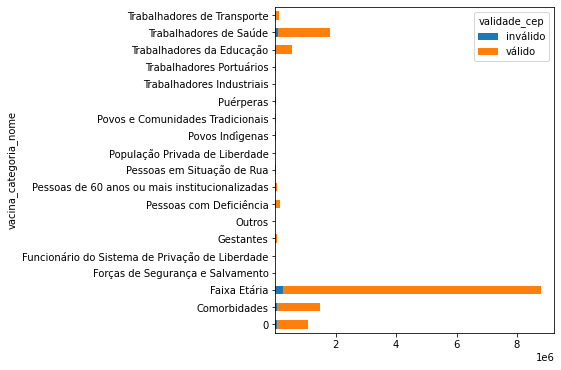

In [12]:
df_categorias_validade = df.pivot_table(values='vacina',index='vacina_categoria_nome',columns='validade_cep',aggfunc='count').reset_index().fillna(0)
df_categorias_validade.plot.barh(x='vacina_categoria_nome',figsize=(5,6),stacked=True)

<AxesSubplot:ylabel='vacina_grupoatendimento_nome'>

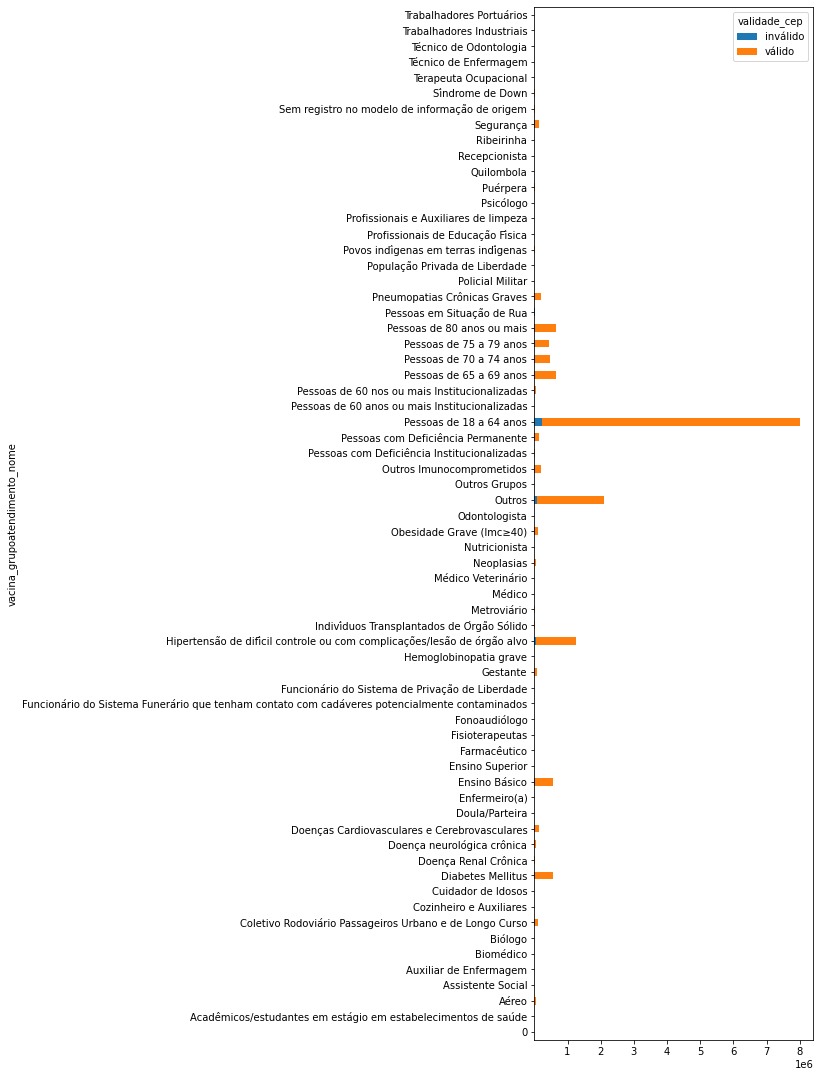

In [15]:
df_grupos_validade = df.pivot_table(values='vacina',index='vacina_grupoatendimento_nome',columns='validade_cep',aggfunc='count').reset_index().fillna(0)
df_grupos_validade.plot.barh(x='vacina_grupoatendimento_nome',figsize=(5,19),stacked=True)

<AxesSubplot:xlabel='quinzena_aplicacao'>

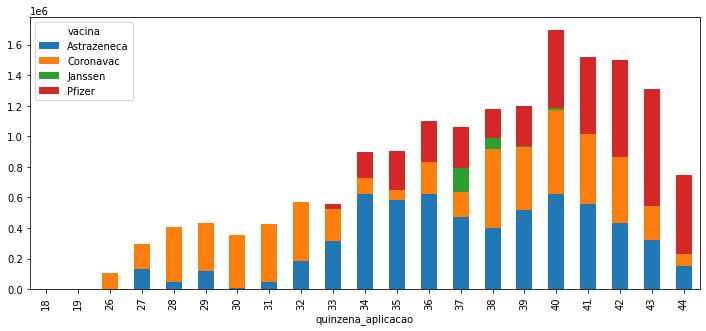

In [14]:
df_quinzena = df.pivot_table(values='char_cep',index='quinzena_aplicacao',columns='vacina',aggfunc='count').reset_index().fillna(0)
df_quinzena.plot.bar(x='quinzena_aplicacao',stacked=True,figsize=(12,5))

<AxesSubplot:xlabel='quinzena_aplicacao'>

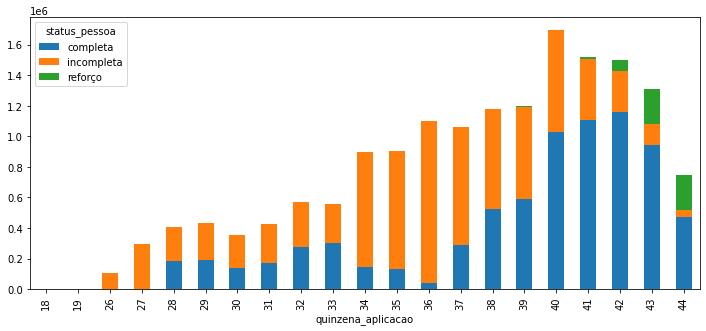

In [16]:
df_quinzena_status = df.pivot_table(values='char_cep',index='quinzena_aplicacao',columns='status_pessoa',aggfunc='count').reset_index().fillna(0)
df_quinzena_status.plot.bar(x='quinzena_aplicacao',stacked=True, figsize=(12,5))

## Cálculo divCEPS

In [17]:
aps = pd.read_csv(filecep,dtype={'LENGTH':float,'CEP':str,'div_CEP':str,'AREA_POND':str})
len_divceps = aps.pivot_table(values='LENGTH',index='div_CEP',aggfunc='sum')
len_divceps = len_divceps.reset_index()

len_aps = aps.pivot_table(values='LENGTH',index=['AREA_POND','div_CEP'],aggfunc='sum')
len_aps = len_aps.reset_index()
len_matriz = len_aps.merge(len_divceps,how='left',on='div_CEP')
len_matriz['pct'] = len_matriz['LENGTH_x']/len_matriz['LENGTH_y']
matriz_divcep = len_matriz[['AREA_POND','div_CEP','pct']]

prim_keys = matriz_divcep.keys()
matriz_divcep.head()

,AREA_POND,div_CEP,pct
0,3503901003001,07400,0.118319
1,3503901003002,07400,0.444118
2,3503901003002,07500,0.001267
3,3503901003002,08584,0.046172
4,3503901003002,08587,0.003587


## Análise imunização

### df doses totais

In [18]:
df_ceps = df.query('validade_cep=="válido"')
df_cep_doses = df_ceps.pivot_table(values='vacina',index='paciente_endereco_cep',aggfunc='count').reset_index().fillna(0)
df_cep_doses = df_cep_doses.rename(columns={'paciente_endereco_cep':'div_CEP','vacina':'doses'})

matriz_divcep = matriz_divcep.merge(df_cep_doses,how='left',on='div_CEP')
df_cep_doses.head()

,div_CEP,doses
0,01000,8058
1,01001,9997
2,01002,179
3,01003,436
4,01004,327


### df imunizações

In [19]:
df_cep_imun = df_ceps.pivot_table(values='grau_imunizacao',index='paciente_endereco_cep',aggfunc='sum').reset_index().fillna(0)
df_cep_imun = df_cep_imun.rename(columns={'paciente_endereco_cep':'div_CEP','grau_imunizacao':'imunizacoes'})

matriz_divcep = matriz_divcep.merge(df_cep_imun,how='left',on='div_CEP')
df_cep_imun.head()

,div_CEP,imunizacoes
0,01000,4083.5
1,01001,5082.0
2,01002,90.5
3,01003,222.5
4,01004,166.5


### df doses totais por vacina

In [20]:
df_cep_doses_vac = df_ceps.pivot_table(values='status_pessoa',index='paciente_endereco_cep',columns='vacina',aggfunc='count').reset_index().fillna(0)
df_cep_doses_vac = df_cep_doses_vac.rename(columns={'paciente_endereco_cep':'div_CEP'})

matriz_divcep = matriz_divcep.merge(df_cep_doses_vac,how='left',on='div_CEP')
df_cep_doses_vac.head()

vacina,div_CEP,Astrazeneca,Coronavac,Janssen,Pfizer
0,01000,3365.0,2661.0,109.0,1923.0
1,01001,3652.0,3457.0,167.0,2721.0
2,01002,69.0,79.0,2.0,29.0
3,01003,181.0,140.0,9.0,106.0
4,01004,121.0,105.0,6.0,95.0


### df completa

In [21]:
df_completa = df.query('status_pessoa=="completa"&validade_cep=="válido"')
df_cep_completa = df_completa.pivot_table(values='vacina',index='paciente_endereco_cep',aggfunc='count').reset_index()
df_cep_completa = df_cep_completa.rename(columns={'paciente_endereco_cep':'div_CEP','vacina':'completa'})

matriz_divcep = matriz_divcep.merge(df_cep_completa,how='left',on='div_CEP')
df_cep_completa.head()

,div_CEP,completa
0,01000,4142
1,01001,4863
2,01002,84
3,01003,191
4,01004,151


### df 1a dose

In [22]:
df_1a_dose = df.query('validade_cep=="válido"&vacina_descricao_dose=="1a Dose"')
df_cep_1a_dose = df_1a_dose.pivot_table(values='vacina',index='paciente_endereco_cep',aggfunc='count').reset_index()
df_cep_1a_dose = df_cep_1a_dose.rename(columns={'paciente_endereco_cep':'div_CEP','vacina':'1a_dose'})

matriz_divcep = matriz_divcep.merge(df_cep_1a_dose,how='left',on='div_CEP')
df_cep_1a_dose.head()

,div_CEP,1a_dose
0,01000,3487
1,01001,4749
2,01002,89
3,01003,225
4,01004,162


### df incompleta

In [23]:
df_cep_incompleta = df['paciente_endereco_cep'].drop_duplicates().to_frame()
df_cep_incompleta = df_cep_incompleta.rename(columns={'paciente_endereco_cep':'div_CEP'})
df_cep_incompleta = df_cep_incompleta.merge(df_cep_1a_dose,on='div_CEP',how='left')
df_cep_incompleta = df_cep_incompleta.merge(df_cep_completa,on='div_CEP',how='left')

df_cep_incompleta['incompleta'] = df_cep_incompleta['1a_dose']-df_cep_incompleta['completa']
df_cep_incompleta = df_cep_incompleta[['div_CEP','incompleta']].dropna(subset=['incompleta'])

df_cep_incompleta.sort_values(by='div_CEP')

,div_CEP,incompleta
2492,01000,-655.0
1056,01001,-114.0
3744,01002,5.0
4283,01003,34.0
4223,01004,11.0
...,...,...
6858,99512,0.0
7602,99560,0.0
7302,99670,0.0
7556,99680,1.0


In [24]:
print('Imunizações completas antes da segunda dose (exceto Janssen):',abs(df_cep_incompleta.query('incompleta<0')['incompleta'].sum()))

Imunizações completas antes da segunda dose (exceto Janssen): 77212.0


### df comorbidades

In [25]:
df_comorbs = df.query('vacina_categoria_nome=="Comorbidades"&validade_cep=="válido"&vacina_descricao_dose=="1a Dose"')
df_cep_comorbs = df_comorbs.pivot_table(values='vacina',index='paciente_endereco_cep',aggfunc='count').reset_index()
df_cep_comorbs = df_cep_comorbs.rename(columns={'paciente_endereco_cep':'div_CEP','vacina':'vac_comorbs'})

matriz_divcep = matriz_divcep.merge(df_cep_comorbs,how='left',on='div_CEP')
df_cep_comorbs.head()

,div_CEP,vac_comorbs
0,01000,719
1,01001,803
2,01002,11
3,01003,24
4,01004,38


### df reforço

In [27]:
df_reforco = df.query('status_pessoa=="reforço"&validade_cep=="válido"')
df_reforco = df_reforco.pivot_table(values='vacina',index='paciente_endereco_cep',columns='status_pessoa',aggfunc='count').reset_index()
df_reforco = df_reforco.rename(columns={'paciente_endereco_cep':'div_CEP','status_pessoa':'reforço'})

matriz_divcep = matriz_divcep.merge(df_reforco,how='left',on='div_CEP')
df_reforco.head()

status_pessoa,div_CEP,reforço
0,01000,429
1,01001,385
2,01002,6
3,01003,20
4,01004,14


### df estratos

In [28]:
df_estratos = df_1a_dose.pivot_table(values='vacina',index='paciente_endereco_cep',columns='estrato_etario',aggfunc='count').reset_index()
df_estratos = df_estratos.rename(columns={'paciente_endereco_cep':'div_CEP'})

matriz_divcep = matriz_divcep.merge(df_estratos,how='left',on='div_CEP')
df_estratos.head()

estrato_etario,div_CEP,0a9,100m,10a19,20a29,30a39,40a49,50a59,60a69,70a79,80a89,90a99
0,01000,NaN,4.0,40.0,63.0,214.0,732.0,1217.0,607.0,307.0,236.0,67.0
1,01001,NaN,6.0,349.0,618.0,714.0,968.0,1060.0,546.0,258.0,173.0,57.0
2,01002,NaN,NaN,1.0,9.0,26.0,13.0,15.0,14.0,7.0,4.0,NaN
3,01003,NaN,NaN,15.0,18.0,22.0,32.0,51.0,46.0,25.0,13.0,3.0
4,01004,NaN,NaN,6.0,8.0,13.0,39.0,39.0,29.0,15.0,11.0,2.0


In [29]:
keys = [x for x in matriz_divcep.keys() if x not in prim_keys]

for k in keys:
    matriz_divcep[k] = matriz_divcep[k]*matriz_divcep['pct']

dout= matriz_divcep.pivot_table(values=keys,index='AREA_POND', aggfunc='sum').reset_index().fillna(0)
dout.head()

,AREA_POND,0a9,100m,10a19,1a_dose,20a29,30a39,40a49,50a59,60a69,...,90a99,Astrazeneca,Coronavac,Janssen,Pfizer,completa,doses,imunizacoes,reforço,vac_comorbs
0,3503901003001,0.000000,0.828231,61.762335,1039.192701,196.172321,223.030655,220.545963,199.130288,73.357563,...,6.744163,849.172949,719.968984,34.549046,495.755143,1000.620821,2099.446122,1066.997584,59.632599,199.366925
1,3503901003002,0.003802,3.113896,254.402512,4107.622460,780.590076,880.072890,866.346493,780.844520,291.758086,...,25.861856,3339.840795,2850.437092,136.710787,1959.163218,3948.257711,8286.151892,4211.431340,230.271721,783.960567
2,3503901003003,0.045640,2.984719,226.656349,3744.298569,709.149381,803.227225,793.497180,714.488727,263.878382,...,23.978141,3052.920352,2595.884512,124.290278,1779.513085,3595.783157,7552.608226,3838.449252,212.526500,713.685409
3,3505708005001,1.062570,3.331732,1097.291278,13668.778382,2376.761440,2989.409844,2940.823747,2254.503171,1115.414141,...,55.660422,10188.910438,9476.106653,536.863214,5923.112680,11736.336545,26124.992984,13330.928099,719.878058,1747.259667
4,3505708005002,1.363627,3.952879,959.904086,10804.118549,2154.746632,2420.201925,2339.980144,1680.115298,743.669650,...,39.931572,7888.747214,7323.760190,380.582852,4643.128654,9039.987486,20236.218909,10308.400880,392.112874,1418.215946


In [30]:
dout.to_csv('Vac_APs_RMSP_20211020.csv',index=False,decimal=',',sep='\t',float_format='%.2f')